In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [17]:
df = pd.read_table('Data/RFP/Sequence_to_Expression.txt')
df.head()

,Date,Time,Media,Ec,OD600,Ex485Em535,Ex550Em650
0,2025_04_25,330_PM,M9,33,0.314510,383540.0,5355.5
1,2025_04_25,330_PM,M9,33,0.340022,388601.0,4213.5
2,2025_04_25,330_PM,M9,34,0.180372,472020.0,92525.5
3,2025_04_25,330_PM,M9,34,0.170433,467968.0,83579.5
4,2025_04_25,330_PM,M9,35,0.083273,124494.0,337765.5


In [4]:
seq_map= pd.read_table('Data/RFP/Sequences.txt')
seq_map.head()

,Ec,Description,sequence
0,33,pClone_GFP,CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT
1,34,P533A,TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA
2,35,P5,TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA
3,36,OsmY,CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACAAA
4,37,OsmY_C12A,CCCGAGCGGTTTCAAAATTGTGATATATATTTAACAAA


In [5]:
df_cut = df[(df['OD600'] > 0.05) & (df['OD600'] < 0.5)]
df_cut = df_cut[df_cut['Media'] == 'M9']
df_cut.head()

,Date,Time,Media,Ec,OD600,Ex485Em535,Ex550Em650
0,2025_04_25,330_PM,M9,33,0.314510,383540.0,5355.5
1,2025_04_25,330_PM,M9,33,0.340022,388601.0,4213.5
2,2025_04_25,330_PM,M9,34,0.180372,472020.0,92525.5
3,2025_04_25,330_PM,M9,34,0.170433,467968.0,83579.5
4,2025_04_25,330_PM,M9,35,0.083273,124494.0,337765.5


In [6]:
def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

In [7]:
seq_map['Ec'] = seq_map['Ec'].astype(int)
df_cut['Ec'] = df_cut['Ec'].astype(int)

merged_df = df_cut.merge(seq_map, on='Ec', how='left')

merged_df['Ex550Em650'] = merged_df.groupby('Ec')['Ex550Em650'].transform('mean')
merged_df = merged_df.drop_duplicates(subset='Ec').reset_index(drop=True)
merged_df.head()

,Date,Time,Media,Ec,OD600,Ex485Em535,Ex550Em650,Description,sequence
0,2025_04_25,330_PM,M9,33,0.314510,383540.0,5426.187500,pClone_GFP,CGATGGTGTCAACGTAAATGCATGCCGCTGGTCTCT
1,2025_04_25,330_PM,M9,34,0.180372,472020.0,110723.312493,P533A,TTAACAATTAATCATCCGGCTCGTAATTTATGTGGA
2,2025_04_25,330_PM,M9,35,0.083273,124494.0,368182.062500,P5,TTGACAATTAATCATCCGGCTCGTAATTTATGTGGA
3,2025_04_25,330_PM,M9,36,0.109528,3340652.0,249438.687500,OsmY,CCCGAGCGGTTTCAAAATTGTGATCTATATTTAACAAA
4,2025_04_25,330_PM,M9,37,0.129405,2741823.0,372264.562500,OsmY_C12A,CCCGAGCGGTTTCAAAATTGTGATATATATTTAACAAA


In [18]:
# The minimum insert length is 34, so 116 is the maximum length of either flanking sequence.

upstream = 'TTTGTGCCCATTAACATCACCATCTAATTCAACAAGAATTGGGACAACTCCAGTGAAAAGTTCTTCTCCTTTACGCATCTAGTATTTCTCCTCTTTAATACTAGAGGTCTTCCGAC'
downstream = 'GCGGGAAGACAACTAGGGGCCCAAGTTCACTTAAAAAGGAGATCAACAATGAAAGCAATTTTCGTACTGAAACATCTTAATCATGCGACGGAGCGTTTCTAATGGCTTCCTCCGAA'

max_flank_length = 116 

In [9]:
CNN_6_1_2 = keras.saving.load_model('Models/CNN_6_1_2.keras')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

merged_df['sequence'] = merged_df['sequence'].str.replace('_', '')
merged_df['log_Rel_RFP'] = np.log(merged_df['Ex550Em650'])

metrics_data = []

def build_sequence(infill, upstream_length, downstream_length):
    """Builds a full sequence with specified flank lengths."""
    upstream_seq = upstream[-(upstream_length - len(infill)):] if upstream_length > len(infill) else ""
    downstream_seq = downstream[:downstream_length]
    sequence = (upstream_seq + infill + downstream_seq)[:150]
    return sequence.zfill(150)

for up_len in range(max_flank_length):
    for down_len in range(max_flank_length):
        if up_len + down_len > max_flank_length:
            continue

        print(f"Processing upstream length: {up_len}, downstream length: {down_len}", end='\r')

        # Build modified sequences
        sequences = [
            build_sequence(row['sequence'], up_len, down_len)
            for _, row in merged_df.iterrows()
        ]
        encoded = np.array([padded_one_hot_encode(seq) for seq in sequences])
        preds = CNN_6_1_2.predict(encoded, verbose=0).flatten()

        # Regression
        X = preds.reshape(-1, 1)
        y = merged_df['log_Rel_RFP'].values.reshape(-1, 1)
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)

        # Store metrics
        metrics_data.append({
            'upstream_length': up_len,
            'downstream_length': down_len,
            'mse': mean_squared_error(y, y_pred),
            'r2': r2_score(y, y_pred),
        })

# Convert to DataFrame
results_df_1 = pd.DataFrame(metrics_data)


In [27]:
results_df_1.sort_values(by=['mse'], ascending=True, inplace=True)
results_df_1.head()

,upstream_length,downstream_length,mse,r2
5067,56,56,0.414753,0.735240
4672,50,48,0.420048,0.731860
4604,49,48,0.421645,0.730840
4394,46,48,0.425146,0.728606
4535,48,48,0.425283,0.728518


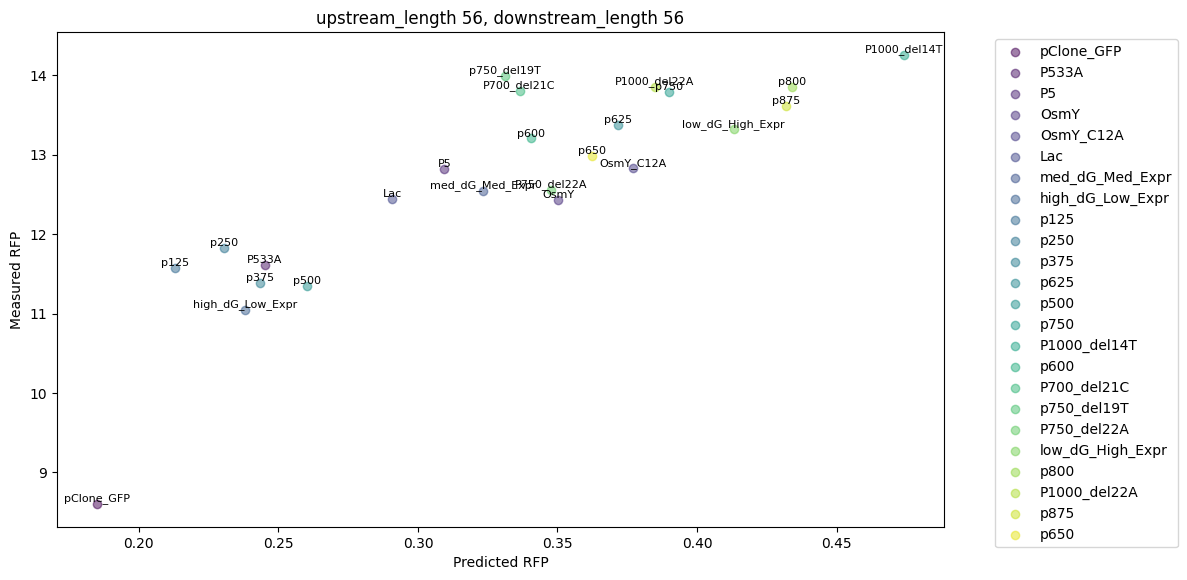

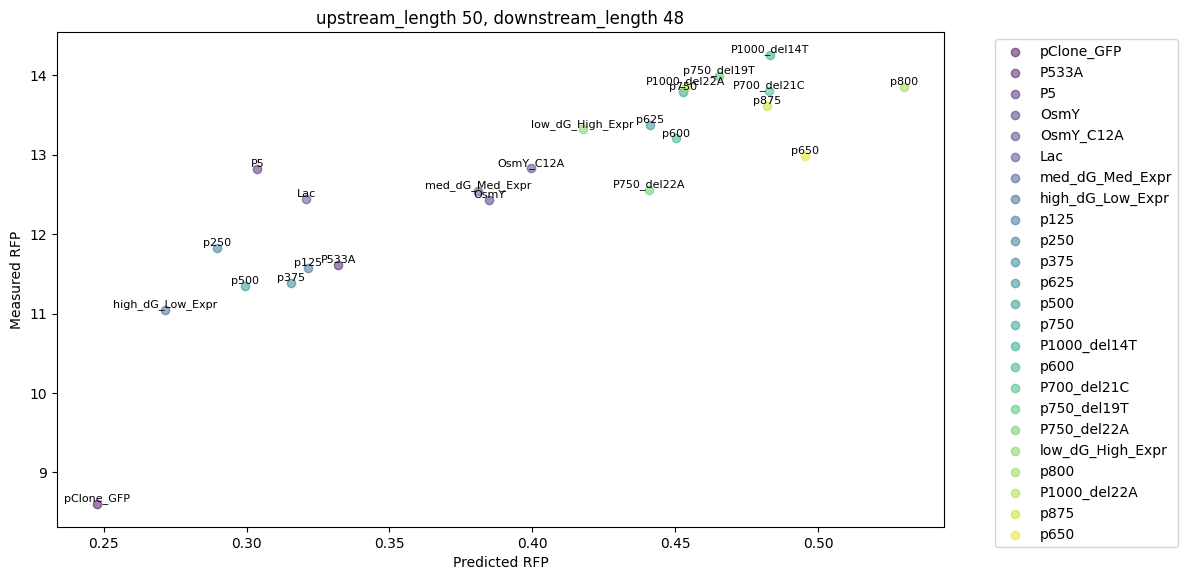

In [111]:
import numpy as np
import matplotlib.pyplot as plt

def build_sequence(infill, upstream_length, downstream_length):
    """Builds a full sequence with specified flank lengths."""
    upstream_seq = upstream[-(upstream_length - len(infill)):] if upstream_length > len(infill) else ""
    downstream_seq = downstream[:downstream_length]
    sequence = (upstream_seq + infill + downstream_seq)[:150]
    return sequence.zfill(150)

lens = [[56, 56], [50, 48]]

# Generate sequences
for up_len, down_len in lens:

    sequences = [
        build_sequence(row['sequence'], up_len, down_len)
        for _, row in merged_df.iterrows()
    ]
    encoded = np.array([padded_one_hot_encode(seq) for seq in sequences])

    merged_df['prediction'] = CNN_6_1_2.predict(encoded, verbose=0).flatten()

    merged_df['Ex550Em650'] = merged_df.groupby('Ec')['Ex550Em650'].transform('mean')
    merged_df = merged_df.drop_duplicates(subset='Ec').reset_index(drop=True)

    unique_descriptions = merged_df['Description'].unique()
    cmap = plt.get_cmap('viridis')
    color_map = {desc: cmap(i / len(unique_descriptions)) for i, desc in enumerate(unique_descriptions)}

    plt.figure(figsize=(12, 6))

    for _, row in merged_df.iterrows():
        plt.scatter(
            row['prediction'], row['log_Rel_RFP'],
            color=color_map[row['Description']],
            alpha=0.5,
            label=row['Description']
        )
        plt.text(row['prediction'], row['log_Rel_RFP'], row['Description'], fontsize=8, ha='center', va='bottom')

    plt.xlabel('Predicted RFP')
    plt.ylabel('Measured RFP')
    plt.title(f'upstream_length {up_len}, downstream_length {down_len}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import itertools

# For print updates
combo_counter = 0
total_combos = sum(
    1 for up_len in range(max_flank_length)
        for down_len in range(max_flank_length)
            for up_padding in range(150 - up_len - down_len + 1)
            if up_len + down_len <= 150
)

merged_df['sequence'] = merged_df['sequence'].str.replace('_', '')
merged_df['log_Rel_RFP'] = np.log(merged_df['Ex550Em650'])

metrics_data = []

def build_sequence(infill, upstream_length, downstream_length, upstream_padding):
    """Builds a full sequence with fixed 150-length, controlling padding position."""
    upstream_seq = upstream[-(upstream_length - len(infill)):] if upstream_length > len(infill) else ""
    downstream_seq = downstream[:downstream_length]
    core_seq = upstream_seq + infill + downstream_seq

    # Determine total padding needed to reach 150
    total_padding = 150 - len(core_seq)
    if total_padding < 0:
        core_seq = core_seq[:150]
        total_padding = 0

    # Ensure upstream_padding doesn't exceed total_padding
    if upstream_padding > total_padding:
        upstream_padding = total_padding
    downstream_padding = total_padding - upstream_padding

    padded_seq = '0' * upstream_padding + core_seq + '0' * downstream_padding
    return padded_seq

for up_len in range(max_flank_length):
    for down_len in range(max_flank_length):
        max_possible_padding = 150 - up_len - down_len
        for up_padding in range(max_possible_padding + 1):
            if up_len + down_len > 150:
                continue

            combo_counter += 1
            print(f"[{combo_counter}/{total_combos}] | "
                  f"Upstream: {up_len}, Downstream: {down_len}, Padding: {up_padding}", end='\r')

            # Generate sequences
            sequences = [
                build_sequence(row['sequence'], up_len, down_len, up_padding)
                for _, row in merged_df.iterrows()
            ]
            encoded = np.array([padded_one_hot_encode(seq) for seq in sequences])
            preds = CNN_6_1_2.predict(encoded, verbose=0).flatten()

            # Linear regression
            X = preds.reshape(-1, 1)
            y = merged_df['log_Rel_RFP'].values.reshape(-1, 1)
            model = LinearRegression().fit(X, y)
            y_pred = model.predict(X)

            metrics_data.append({
                'upstream_length': up_len,
                'downstream_length': down_len,
                'upstream_padding': up_padding,
                'mse': mean_squared_error(y, y_pred),
                'r2': r2_score(y, y_pred),
            })

# Store results
results_df_2 = pd.DataFrame(metrics_data)

In [70]:
results_df_2.sort_values(by='mse', ascending=True).head(10)

,upstream_length,downstream_length,upstream_padding,mse,r2
441140,58,25,24,0.286903,0.816854
441208,58,26,24,0.290166,0.814771
436701,57,25,25,0.298187,0.809651
441890,58,37,24,0.301276,0.807679
436770,57,26,25,0.302647,0.806803
432167,56,25,26,0.312376,0.800593
445552,59,26,23,0.312968,0.800215
437463,57,37,25,0.316907,0.797700
441833,58,36,24,0.319982,0.795738
432237,56,26,26,0.323569,0.793448


In [83]:
results_df_2[results_df_2['mse'] > 0.6].sort_values(by='mse', ascending=True).head(10)


,upstream_length,downstream_length,upstream_padding,mse,r2
527677,85,4,29,0.600060,0.616948
334939,38,48,42,0.600065,0.616945
318970,36,14,75,0.600078,0.616937
374982,45,16,56,0.600078,0.616937
449830,60,26,49,0.600087,0.616931
331857,38,11,68,0.600092,0.616928
403012,50,26,56,0.600118,0.616911
517908,81,0,42,0.600120,0.616910
482907,69,8,57,0.600129,0.616904
399033,49,45,31,0.600132,0.616902


In [ ]:
# results_df_1.to_csv('Data/RFP/Results_1.csv', index=False)
# results_df_2.to_csv('Data/RFP/Results_2.csv', index=False)

In [12]:
results_df_1 = pd.read_csv('Data/RFP/Results_1.csv')
results_df_2 = pd.read_csv('Data/RFP/Results_2.csv')

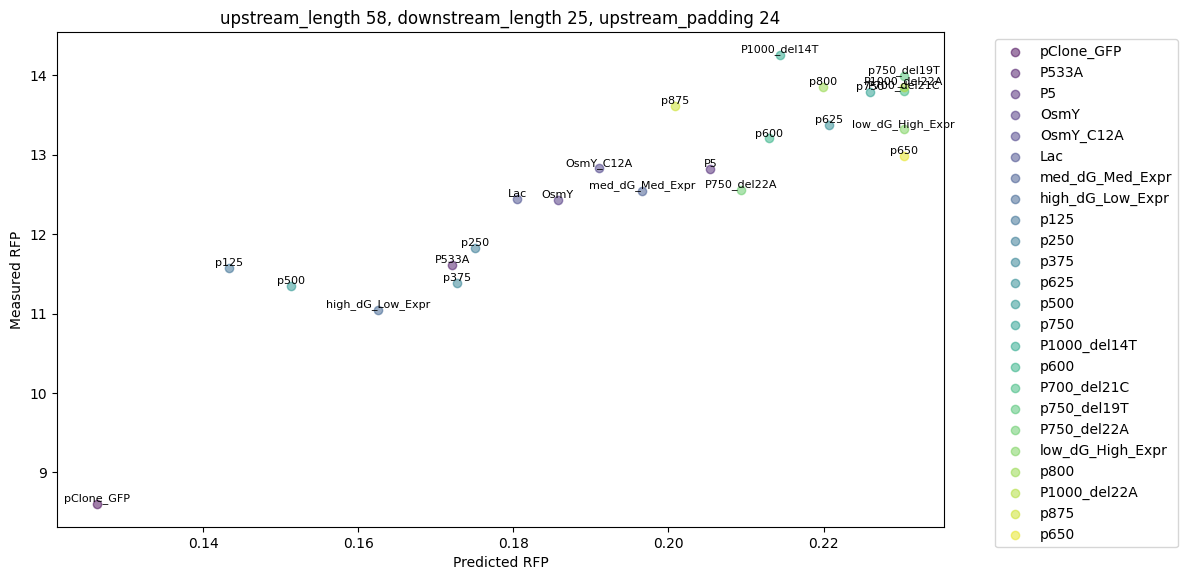

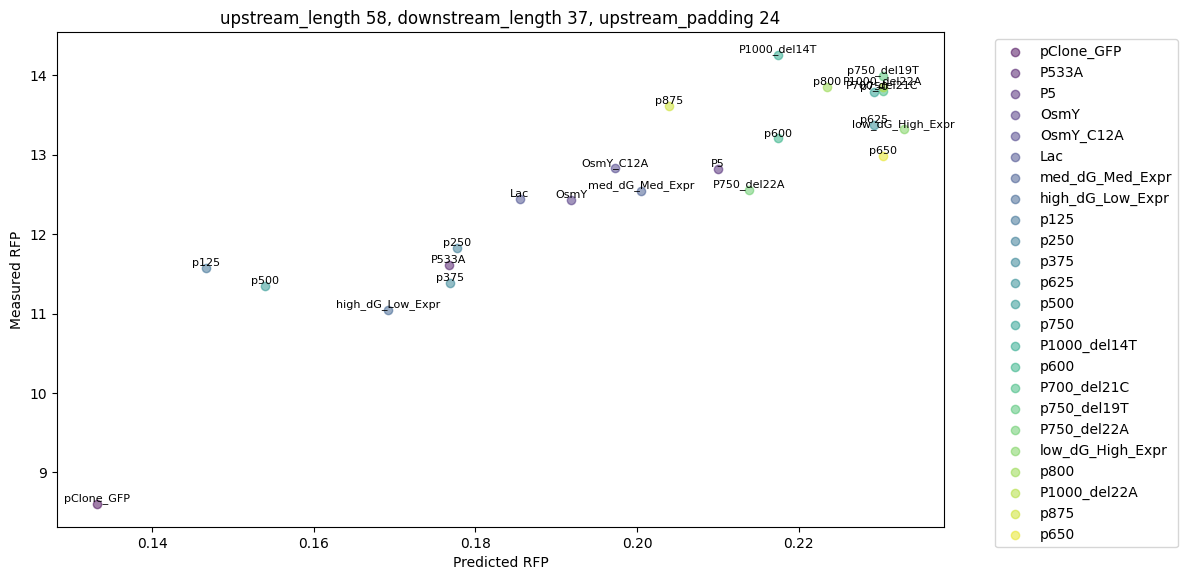

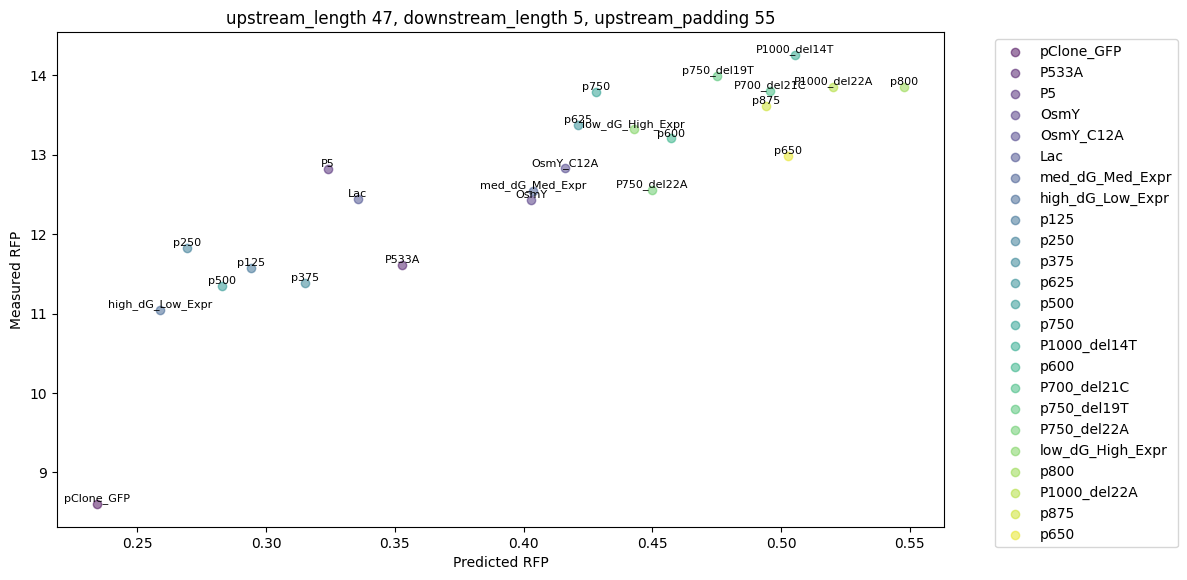

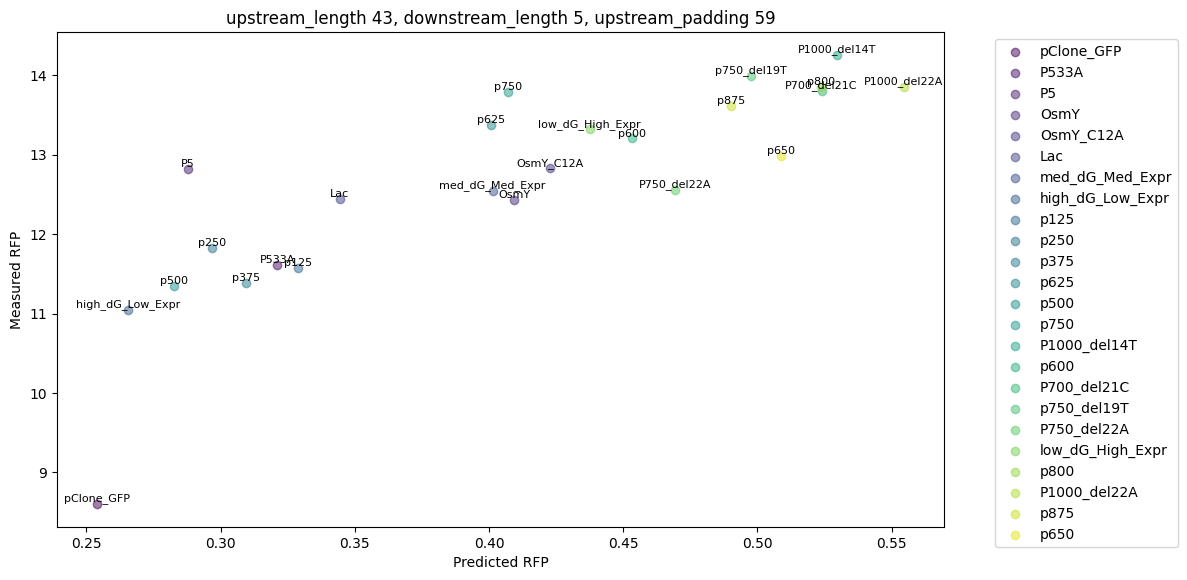

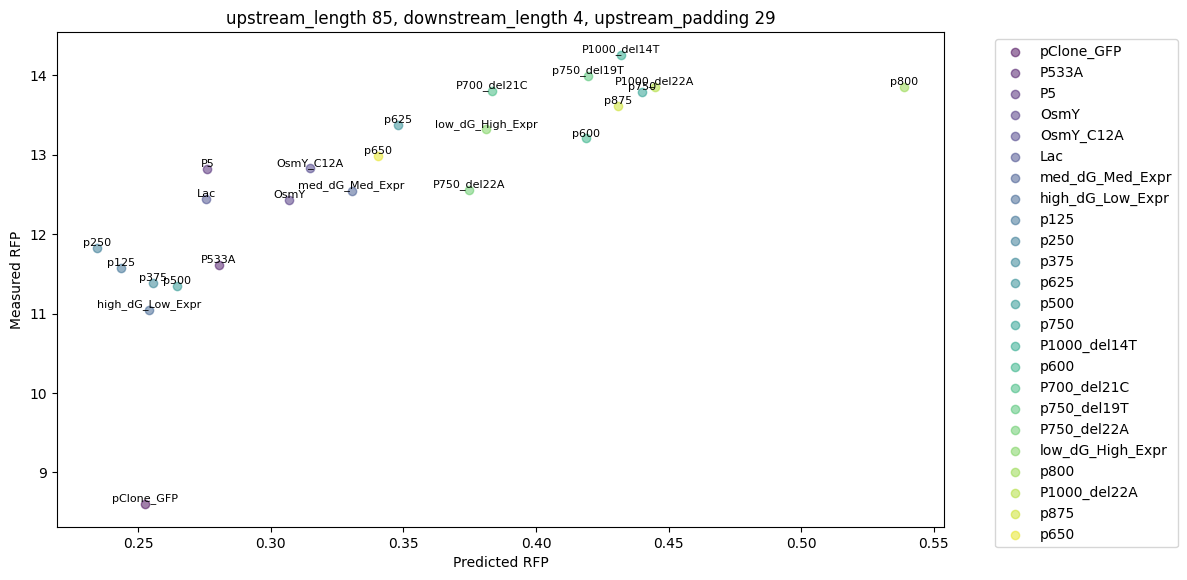

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def build_sequence(infill, upstream_length, downstream_length, upstream_padding):
    """Builds a full sequence with fixed 150-length, controlling padding position."""
    upstream_seq = upstream[-(upstream_length - len(infill)):] if upstream_length > len(infill) else ""
    downstream_seq = downstream[:downstream_length]
    core_seq = upstream_seq + infill + downstream_seq

    # Determine total padding needed to reach 150
    total_padding = 150 - len(core_seq)
    if total_padding < 0:
        core_seq = core_seq[:150]
        total_padding = 0

    # Ensure upstream_padding doesn't exceed total_padding
    if upstream_padding > total_padding:
        upstream_padding = total_padding
    downstream_padding = total_padding - upstream_padding

    padded_seq = '0' * upstream_padding + core_seq + '0' * downstream_padding
    return padded_seq

lens = [[58, 25, 24], [58, 37, 24], [47, 5, 55], [43, 5, 59], [85, 4, 29]]

# Generate sequences
for up_len, down_len, up_padding in lens:

    sequences = [
        build_sequence(row['sequence'], up_len, down_len, up_padding)
        for _, row in merged_df.iterrows()
    ]
    encoded = np.array([padded_one_hot_encode(seq) for seq in sequences])

    merged_df['prediction'] = CNN_6_1_2.predict(encoded, verbose=0).flatten()

    merged_df['Ex550Em650'] = merged_df.groupby('Ec')['Ex550Em650'].transform('mean')
    merged_df = merged_df.drop_duplicates(subset='Ec').reset_index(drop=True)

    unique_descriptions = merged_df['Description'].unique()
    cmap = plt.get_cmap('viridis')
    color_map = {desc: cmap(i / len(unique_descriptions)) for i, desc in enumerate(unique_descriptions)}

    plt.figure(figsize=(12, 6))

    for _, row in merged_df.iterrows():
        plt.scatter(
            row['prediction'], row['log_Rel_RFP'],
            color=color_map[row['Description']],
            alpha=0.5,
            label=row['Description']
        )
        plt.text(row['prediction'], row['log_Rel_RFP'], row['Description'], fontsize=8, ha='center', va='bottom')

    plt.xlabel('Predicted RFP')
    plt.ylabel('Measured RFP')
    plt.title(f'upstream_length {up_len}, downstream_length {down_len}, upstream_padding {up_padding}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


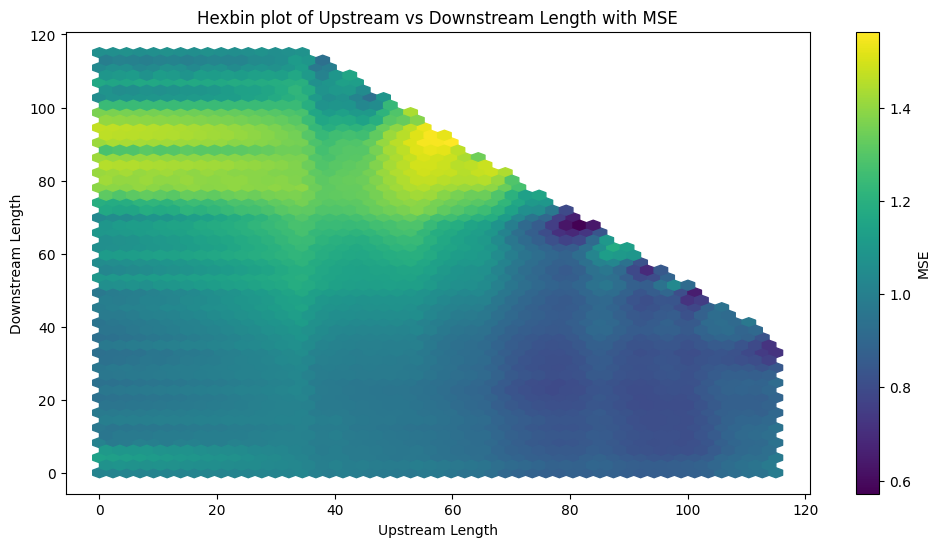

In [ ]:
# make a hexbin plot of upstream_length vs downstream_length with color based on mse

plt.figure(figsize=(12, 6))
plt.hexbin(results_df_2['upstream_length'], results_df_2['downstream_length'], 
           C=results_df_2['mse'], gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='MSE')
plt.xlabel('Upstream Length')
plt.ylabel('Downstream Length')
plt.title('Hexbin plot of Upstream vs Downstream Length with MSE')
plt.show()

In [ ]:
# make a hexbin plot of upstream_length vs downstream_length with color based on mse

plt.figure(figsize=(12, 6))
plt.hexbin(results_df_2['upstream_length'], results_df_2['downstream_length'], 
           C=results_df_2['mse'], gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='MSE')
plt.xlabel('Upstream Length')
plt.ylabel('Downstream Length')
plt.title('Hexbin plot of Upstream vs Downstream Length with MSE')
plt.show()


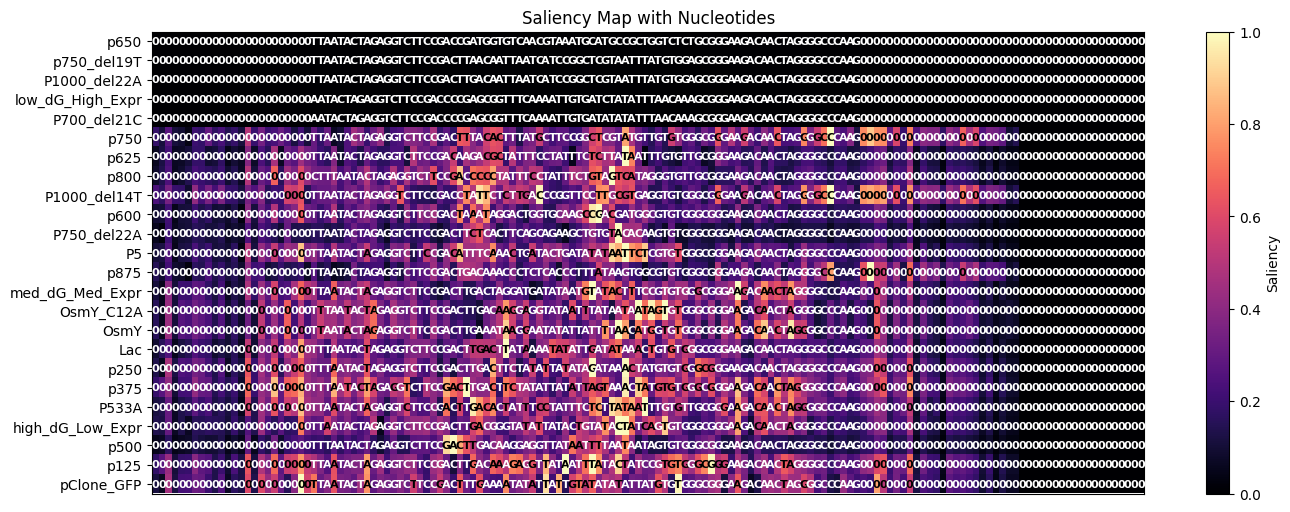

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def build_sequence(infill, upstream_length, downstream_length, upstream_padding):
    """Builds a full sequence with fixed 150-length, controlling padding position."""
    upstream_seq = upstream[-(upstream_length - len(infill)):] if upstream_length > len(infill) else ""
    downstream_seq = downstream[:downstream_length]
    core_seq = upstream_seq + infill + downstream_seq

    # Determine total padding needed to reach 150
    total_padding = 150 - len(core_seq)
    if total_padding < 0:
        core_seq = core_seq[:150]
        total_padding = 0

    # Ensure upstream_padding doesn't exceed total_padding
    if upstream_padding > total_padding:
        upstream_padding = total_padding
    downstream_padding = total_padding - upstream_padding

    padded_seq = '0' * upstream_padding + core_seq + '0' * downstream_padding
    return padded_seq


def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

def pad_sequence(sequence):
    sequence = sequence.replace('_', '')
    return sequence.zfill(150)

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

model_filename='Models/CNN_6_1_2.keras'
model = load_model(model_filename)

up_len = 58
down_len = 25
up_padding = 24

sequences = [
    build_sequence(row['sequence'], up_len, down_len, up_padding)
    for _, row in merged_df.iterrows()
]
y_subset = merged_df['Ex550Em650']

predictions = []
descriptions = merged_df['Description'].unique()
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    seq_padded = pad_sequence(seq)
    encoded_seq = np.array(padded_one_hot_encode(seq_padded))

    pred = model(tf.convert_to_tensor(encoded_seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, encoded_seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
descriptions = [descriptions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

sequences_cleaned = [pad_sequence(seq) for seq in sequences]
nucleotide_matrix = np.array([list(seq) for seq in sequences_cleaned])

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = saliency_matrix[i, j]
        norm_value = (value - saliency_matrix.min()) / (saliency_matrix.max() - saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()

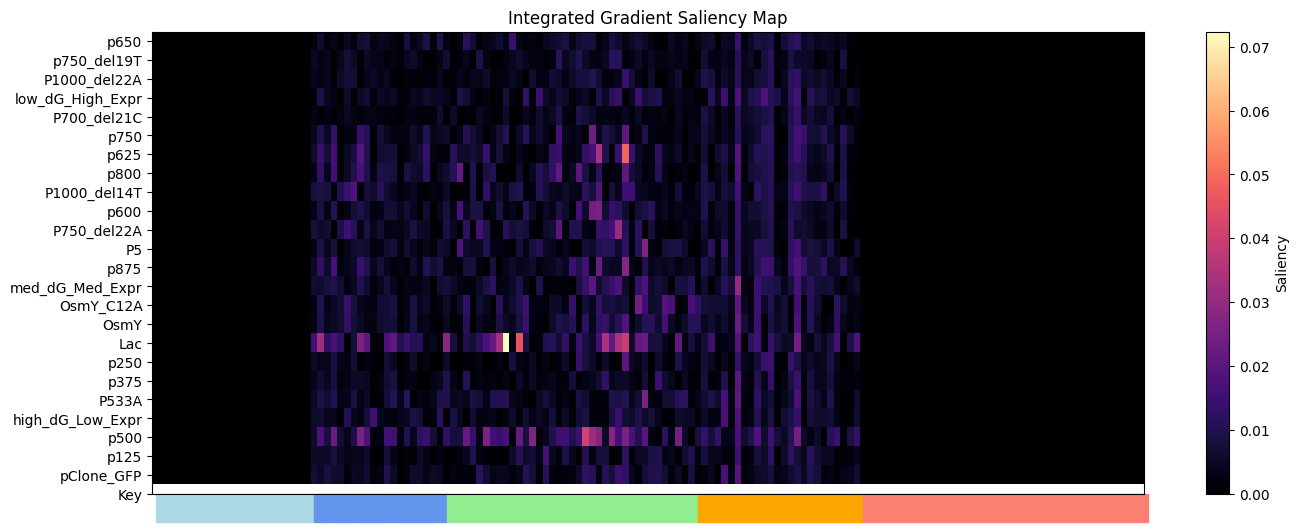

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import Patch

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

def pad_sequence(sequence):
    sequence = sequence.replace('_', '')
    return sequence.zfill(150)

def build_sequence(infill, upstream_length, downstream_length, upstream_padding):
    """Builds a full sequence with fixed 150-length, controlling padding position."""
    upstream_seq = upstream[-(upstream_length - len(infill)):] if upstream_length > len(infill) else ""
    downstream_seq = downstream[:downstream_length]
    core_seq = upstream_seq + infill + downstream_seq

    # Determine total padding needed to reach 150
    total_padding = 150 - len(core_seq)
    if total_padding < 0:
        core_seq = core_seq[:150]
        total_padding = 0

    # Ensure upstream_padding doesn't exceed total_padding
    if upstream_padding > total_padding:
        upstream_padding = total_padding
    downstream_padding = total_padding - upstream_padding

    padded_seq = '0' * upstream_padding + core_seq + '0' * downstream_padding
    return padded_seq

def integrated_gradients(model, input_array, baseline=None, steps=50):
    input_tensor = tf.convert_to_tensor(input_array, dtype=tf.float32)
    if baseline is None:
        baseline = tf.zeros_like(input_tensor)
    baseline = tf.cast(baseline, tf.float32)
    input_tensor = tf.cast(input_tensor, tf.float32)

    interpolated_inputs = tf.stack([
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(steps + 1)
    ])

    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)

    grads = tape.gradient(predictions, interpolated_inputs)
    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grad = (input_tensor - baseline) * avg_grads
    return tf.norm(integrated_grad, axis=-1).numpy()

# ------------------------ Load Model and Prepare Data ------------------------

model_filename = 'Models/CNN_6_1_2.keras'
model = load_model(model_filename)

up_len = 58
down_len = 25
up_padding = 24

sequences = [
    build_sequence(row['sequence'], up_len, down_len, up_padding)
    for _, row in merged_df.iterrows()
]
y_subset = merged_df['Ex550Em650']
descriptions = merged_df['Description'].unique()

# Compute saliency maps
predictions, saliency_maps, relative_saliency_maps = [], [], []
for seq in sequences:
    seq_padded = pad_sequence(seq)
    encoded_seq = np.array(padded_one_hot_encode(seq_padded))
    pred = model(tf.convert_to_tensor(encoded_seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(integrated_gradients(model, encoded_seq))
    saliency = np.nan_to_num(saliency)
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
descriptions = [descriptions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

# Matrix prep
saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)
sequences_cleaned = [pad_sequence(seq) for seq in sequences]
nucleotide_matrix = np.array([list(seq) for seq in sequences_cleaned])

# ------------------------- Add Region Key -------------------------

# Estimate infill length (use max or average if unknown)
infill_len = max(len(seq.replace('_', '')) for seq in merged_df['sequence'])
upstream_seq_len = up_len - infill_len
core_len = upstream_seq_len + infill_len + down_len
downstream_padding = 150 - (up_padding + core_len)

key_row = (
    [0] * up_padding +
    [1] * upstream_seq_len +
    [2] * infill_len +
    [3] * down_len +
    [4] * downstream_padding
)
key_row = np.array(key_row)
saliency_matrix = np.vstack([saliency_matrix, key_row])
descriptions_with_key = list(descriptions) + ['Key']

# ------------------------- Plot -------------------------

plt.figure(figsize=(16, 6))
im = plt.imshow(
    saliency_matrix[:-1],
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix[:-1].min(),
    vmax=saliency_matrix[:-1].max()
)

key_colors = {
    0: 'lightblue',
    1: 'cornflowerblue',
    2: 'lightgreen',
    3: 'orange',
    4: 'salmon'
}

ax = plt.gca()
for j in range(150):
    val = int(key_row[j])
    rect = plt.Rectangle(
        (j, len(saliency_matrix)-1), 1, 1.5,
        color=key_colors[val],
        transform=ax.transData,
        clip_on=False
    )
    ax.add_patch(rect)

plt.yticks(np.arange(len(descriptions_with_key)), descriptions_with_key, rotation=0, ha='right')
plt.xticks([])

plt.colorbar(im, label='Saliency')
plt.title('Integrated Gradient Saliency Map')
plt.show()


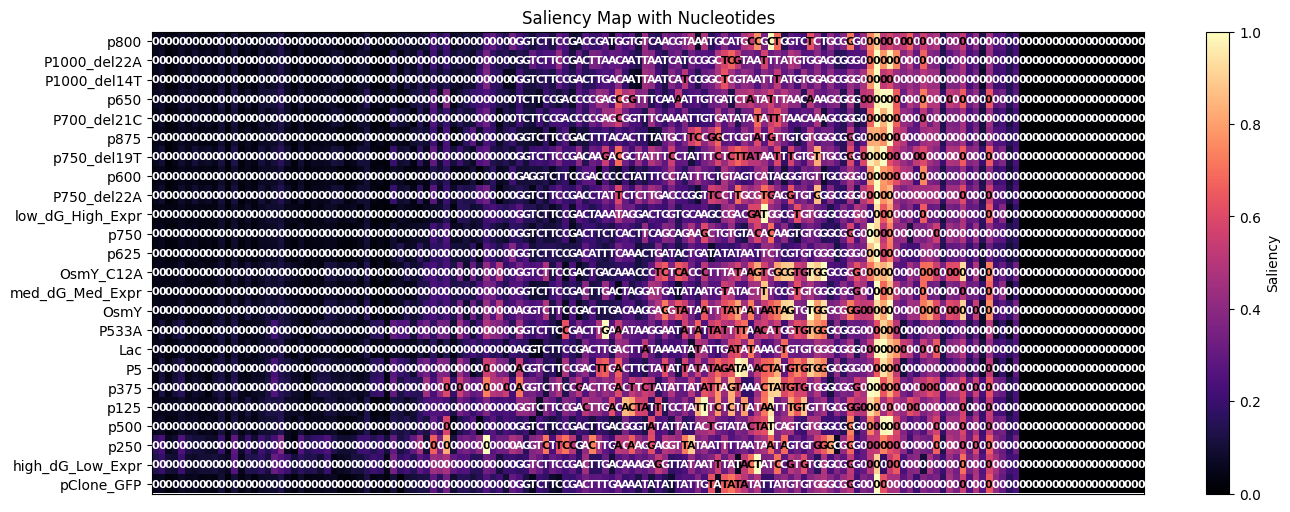

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = [mapping[nucleotide.upper()] for nucleotide in sequence]
    return encoding

def pad_sequence(sequence):
    sequence = sequence.replace('_', '')
    return sequence.zfill(150)

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

model_filename='Models/CNN_6_1_2.keras'
model = load_model(model_filename)

up_len = 47
down_len = 5
up_padding = 55

sequences = [
    build_sequence(row['sequence'], up_len, down_len, up_padding)
    for _, row in merged_df.iterrows()
]
y_subset = merged_df['Ex550Em650']

predictions = []
descriptions = merged_df['Description'].unique()
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    seq_padded = pad_sequence(seq)
    encoded_seq = np.array(padded_one_hot_encode(seq_padded))

    pred = model(tf.convert_to_tensor(encoded_seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, encoded_seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
descriptions = [descriptions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

sequences_cleaned = [pad_sequence(seq) for seq in sequences]
nucleotide_matrix = np.array([list(seq) for seq in sequences_cleaned])

# -------------------- Plot Relative Saliency Maps with Nucleotides --------------------

# plt.figure(figsize=(16, 6))
# plt.imshow(
#     relative_saliency_matrix,
#     cmap='magma',
#     aspect='auto',
#     vmin=relative_saliency_matrix.min(),
#     vmax=relative_saliency_matrix.max()
# )

# for i in range(nucleotide_matrix.shape[0]):
#     for j in range(nucleotide_matrix.shape[1]):
#         value = relative_saliency_matrix[i, j]

#         norm_value = (value - relative_saliency_matrix.min()) / (relative_saliency_matrix.max() - relative_saliency_matrix.min())
#         text_color = 'black' if norm_value > 0.5 else 'white'

#         plt.text(
#             j, i, nucleotide_matrix[i, j],
#             ha='center', va='center',
#             color=text_color, fontsize=8, fontweight='bold'
#         )

# plt.xticks([])
# plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

# plt.colorbar(label='Relative Saliency')
# plt.title('Relative Saliency Map with Nucleotides')
# plt.show()

# ------------------------- Plot Saliency Maps with Nucleotides -------------------------

plt.figure(figsize=(16, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)

for i in range(nucleotide_matrix.shape[0]):
    for j in range(nucleotide_matrix.shape[1]):
        value = saliency_matrix[i, j]
        norm_value = (value - saliency_matrix.min()) / (saliency_matrix.max() - saliency_matrix.min())
        text_color = 'black' if norm_value > 0.5 else 'white'

        plt.text(
            j, i, nucleotide_matrix[i, j],
            ha='center', va='center',
            color=text_color, fontsize=8, fontweight='bold'
        )

plt.xticks([])
plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

plt.colorbar(label='Saliency')
plt.title('Saliency Map with Nucleotides')
plt.show()

# # ------------------------- Plot Saliency Maps with Nucleotides -------------------------

# plt.figure(figsize=(16, 6))
# plt.imshow(
#     saliency_matrix,
#     cmap='magma',
#     aspect='auto',
#     vmin=saliency_matrix.min(),
#     vmax=saliency_matrix.max()
# )

# plt.xticks([])
# plt.yticks(np.arange(len(merged_df)), descriptions, rotation=0, ha='right')

# plt.colorbar(label='Saliency')
# plt.title('Saliency Map with Nucleotides')
# plt.show()